<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences


from keras.models import Model, Sequential
from keras.layers import Input, Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN

from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 21.8MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
data[0]

{'dialog': [{'id': 0,
   'sender': 'participant1',
   'text': 'hi there',
   'evaluation_score': None,
   'sender_class': 'Human'}],
 'start_time': '2018-10-29 03:32:08.296000',
 'end_time': '2018-10-29 03:32:08.296000',
 'bot_profile': ['i like to talk but people have a hard time understanding.',
  'i like to look at blocks and sing about letters.',
  'i like to eat chocolate candy.',
  'when i grow up i want to be a dog.'],
 'user_profile': ['i am a clean eater.',
  'my parents were both very athletic.',
  'i love running and preparing for marathons.',
  'i am a cancer survivor.'],
 'eval_score': None,
 'profile_match': '',
 'participant1_id': {'class': 'User', 'user_id': 'User 00172'},
 'participant2_id': {'class': 'Bot', 'user_id': 'Bot 004'}}

In [7]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []

CHAT_MAX_CHARS = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

n_discarded = 0
for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= CHAT_MAX_CHARS or len(chat_out) >= CHAT_MAX_CHARS:
          n_discarded += 1
          continue

        input_sentence, output = chat_in, chat_out

        # output sentence: (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input: (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows consumidas:", len(input_sentences))
print("Cantidad de rows descartadas:", n_discarded)

Cantidad de rows consumidas: 6033
Cantidad de rows descartadas: 7479


In [8]:
print("Ejemplo de entradas y salidas:")
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

Ejemplo de entradas y salidas:


('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

# Resolución

Configuraciones recomendadas:

*  MAX_VOCAB_SIZE = 8000
*  max_length ~ 10
*  Embeddings 300 Fasttext
*  n_units = 128
*  LSTM Dropout 0.2
*  Epochs 30~50

In [9]:
MAX_VOCAB_SIZE = 8000
max_length = 10
n_units = 128
dropout_p = 0.2
epochs = 30

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [10]:
from keras.preprocessing.text import Tokenizer

In [11]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)

input_sequences = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_input = input_tokenizer.word_index
print("Palabras en el vocabulario en la entrada:", len(word2idx_input))

max_input_len = max(len(sen) for sen in input_sequences)
print("Sentencia de entrada más larga:", max_input_len)

input_len = min(max_length, max_input_len)
print("Tamaño de sentencia de entrada:", input_len)

Palabras en el vocabulario en la entrada: 1799
Sentencia de entrada más larga: 9
Tamaño de sentencia de entrada: 9


In [12]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='"#$%&()*+-./:;=¿@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)

output_sequences = output_tokenizer.texts_to_sequences(output_sentences)
output_sequences_input = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_output = output_tokenizer.word_index
print("Palabras en el vocabulario en la salida:", len(word2idx_output))

max_output_len = max(len(sen) for sen in output_sequences)
print("Sentencia de salida más larga:", max_output_len)

output_len = min(max_length, max_output_len)
print("Tamaño de sentencia de salida:", output_len)

Palabras en el vocabulario en la salida: 1806
Sentencia de salida más larga: 10
Tamaño de sentencia de salida: 10


In [13]:
print("Cantidad de rows del dataset:", len(input_sequences))

encoder_input_sequences = pad_sequences(input_sequences, maxlen=input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_sequences_input, maxlen=output_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


In [14]:
from keras.utils import to_categorical

num_palabras_output = min(len(word2idx_output) + 1, MAX_VOCAB_SIZE)

decoder_output_sequences = pad_sequences(output_sequences, maxlen=output_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_palabras_output)
decoder_targets.shape

(6033, 10, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [15]:
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=4d320c10-0de1-40ce-9bd1-de9debaa4d73
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:04<00:00, 114MB/s] 


In [16]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

In [17]:
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

In [18]:
model_embeddings = GloveEmbeddings()

In [19]:
def getEmbeddingsMatrix(model, word2idx):
  embed_dim = model.N_FEATURES
  words_not_found = []

  nb_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
  embedding_matrix = np.zeros((nb_words, embed_dim))

  for word, i in word2idx.items():
      if i > nb_words:
          print('Se alcanzó la cantidad máxima de palabras')
          break

      embedding_vector = model_embeddings.get_words_embeddings(word)[0]
      if (embedding_vector is not None) and len(embedding_vector) > 0:
          embedding_matrix[i] = embedding_vector
      else:
          # words not found in embedding index will be all-zeros.
          words_not_found.append(word)

  print('Palabras no encontradas', words_not_found)
  print('Cantidad de embeddings nulos:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))
  print('Shape de la matriz de embeddings:', embedding_matrix.shape)

  return embedding_matrix

In [20]:
encoder_embedding_matrix = getEmbeddingsMatrix(model_embeddings, word2idx_input)
decoder_embedding_matrix = getEmbeddingsMatrix(model_embeddings, word2idx_output)

Palabras no encontradas []
Cantidad de embeddings nulos: 38
Shape de la matriz de embeddings: (1800, 50)
Palabras no encontradas []
Cantidad de embeddings nulos: 42
Shape de la matriz de embeddings: (1807, 50)


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [114]:
dropout_p = 0.5

n_units = 128
layer2_n_units = 32

from keras import backend as K
K.clear_session()

#### Encoder

In [115]:
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_input) + 1)

# Definición de las capas
encoder_inputs = Input(shape=(input_len))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,
          output_dim=model_embeddings.N_FEATURES,
          input_length=input_len,
          weights=[encoder_embedding_matrix],
          trainable=False)

encoder_lstm_1 = LSTM(n_units, return_sequences=True, return_state=True)
encoder_dopout_1 = Dropout(dropout_p)

encoder_lstm_2 = LSTM(layer2_n_units, return_state=True)

# Conexión entre las de capas
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder_output_lstm1, state_h_1, state_c_1 = encoder_lstm_1(encoder_inputs_x)
_, state_h_2, state_c_2 = encoder_lstm_2(encoder_dopout_1(encoder_output_lstm1))

encoder_states_l1 = [state_h_1, state_c_1]
encoder_states_l2 = [state_h_2, state_c_2]
encoder_states = encoder_states_l1 + encoder_states_l2

#### Decoder (train)

In [116]:
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_output) + 1)

# Definición de las capas
decoder_inputs = Input(shape=(output_len))

decoder_embedding_layer = Embedding(
          input_dim=nb_words,
          output_dim=model_embeddings.N_FEATURES,
          input_length=output_len,
          weights=[decoder_embedding_matrix],
          trainable=False)

decoder_lstm_1 = LSTM(n_units, return_sequences=True, return_state=True)
decoder_dopout_1 = Dropout(dropout_p)

decoder_lstm_2 = LSTM(layer2_n_units, return_sequences=True, return_state=True)

decoder_dense = Dense(num_palabras_output, activation='softmax')

# Conexión entre las de capas
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm_1_output, _, _ = decoder_lstm_1(decoder_inputs_x, initial_state=encoder_states_l1)
decoder_lstm_2_output, _, _ = decoder_lstm_2(decoder_dopout_1(decoder_lstm_1_output), initial_state=encoder_states_l2)

decoder_outputs = decoder_dense(decoder_lstm_2_output)

In [117]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 9, 50)                90000     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 10, 50)               90350     ['input_2[0][0]']             
                                                                                              

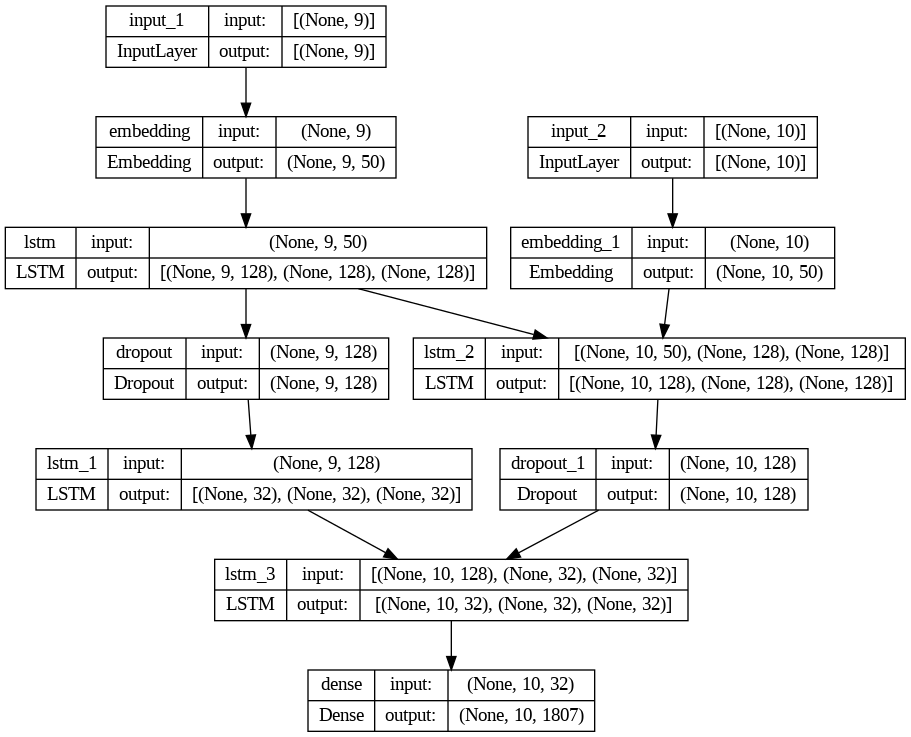

In [118]:
# Modelo completo (encoder+decoder) para poder entrenar
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

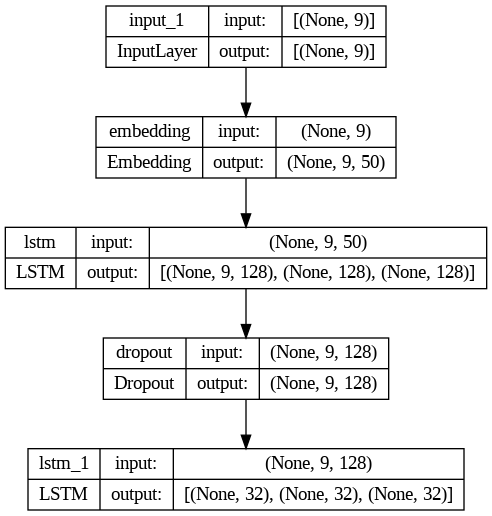

In [119]:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

#### Decoder (predict)

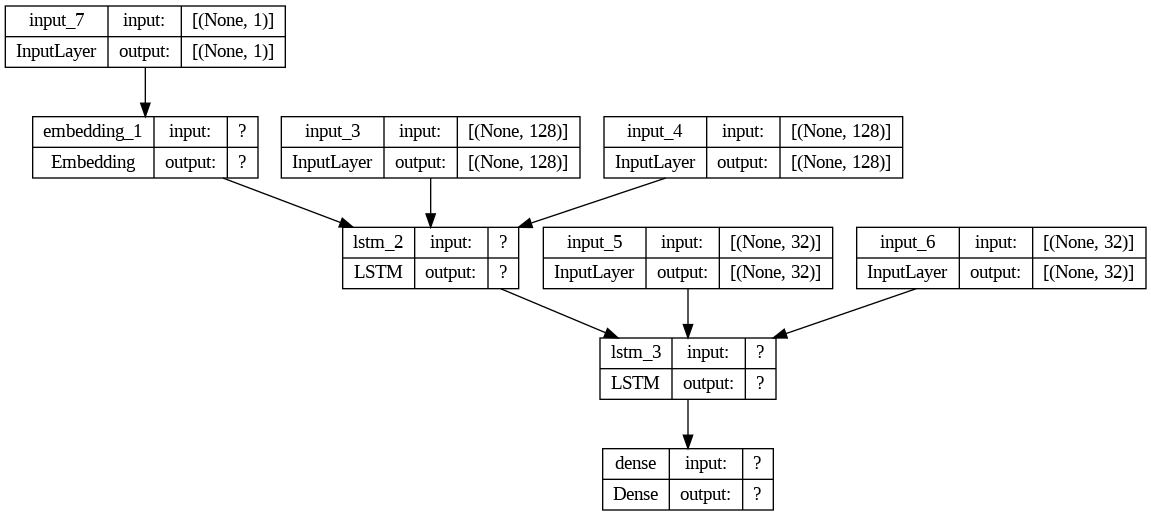

In [120]:
decoder_state_input_h_1 = Input(shape=(n_units,))
decoder_state_input_c_1 = Input(shape=(n_units,))

decoder_state_input_h_2 = Input(shape=(layer2_n_units,))
decoder_state_input_c_2 = Input(shape=(layer2_n_units,))

decoder_states_inputs_1 = [decoder_state_input_h_1, decoder_state_input_c_1]
decoder_states_inputs_2 = [decoder_state_input_h_2, decoder_state_input_c_2]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_lstm_1_output, state_h_1, state_c_1 = decoder_lstm_1(decoder_inputs_single_x, initial_state=decoder_states_inputs_1)
decoder_lstm_2_output, state_h_2, state_c_2 = decoder_lstm_2(decoder_lstm_1_output, initial_state=decoder_states_inputs_2)

decoder_states_1 = [state_h_1, state_c_1]
decoder_states_2 = [state_h_2, state_c_2]

decoder_outputs = decoder_dense(decoder_lstm_2_output)

decoder_model = Model([decoder_inputs_single] + decoder_states_inputs_1 + decoder_states_inputs_2,
 [decoder_outputs] + decoder_states_1 + decoder_states_2)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [121]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=55,
    validation_split=0.3)

Epoch 1/55
132/132 [==============================] - 9s 22ms/step - loss: 4.5330 - accuracy: 0.4829 - val_loss: 3.0328 - val_accuracy: 0.5101
Epoch 2/55
132/132 [==============================] - 1s 11ms/step - loss: 2.9729 - accuracy: 0.4885 - val_loss: 2.9102 - val_accuracy: 0.5101
Epoch 3/55
132/132 [==============================] - 1s 11ms/step - loss: 2.7344 - accuracy: 0.4885 - val_loss: 2.5258 - val_accuracy: 0.5101
Epoch 4/55
132/132 [==============================] - 1s 11ms/step - loss: 2.3936 - accuracy: 0.5513 - val_loss: 2.3066 - val_accuracy: 0.6312
Epoch 5/55
132/132 [==============================] - 1s 11ms/step - loss: 2.2380 - accuracy: 0.6117 - val_loss: 2.2107 - val_accuracy: 0.6313
Epoch 6/55
132/132 [==============================] - 1s 11ms/step - loss: 2.1434 - accuracy: 0.6138 - val_loss: 2.1502 - val_accuracy: 0.6446
Epoch 7/55
132/132 [==============================] - 1s 11ms/step - loss: 2.0703 - accuracy: 0.6302 - val_loss: 2.0955 - val_accuracy: 0.6512

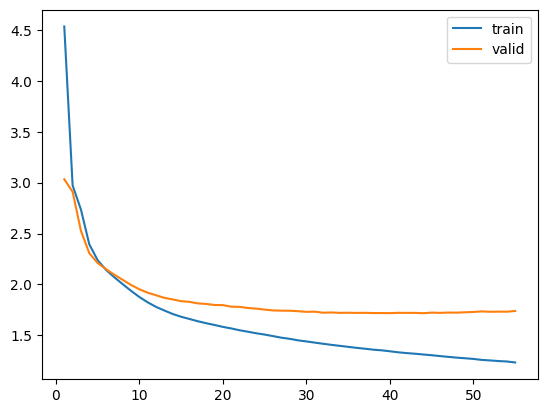

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [123]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_input.items()}
idx2word_target = {v:k for k, v in word2idx_output.items()}

In [124]:
def get_answer_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_output['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_output['<eos>']

    output_sentence = []
    for _ in range(output_len):
        # Predicción del próximo elemento
        output_tokens, h1, c1, h2, c2 = decoder_model.predict([target_seq] + states_value, verbose=0)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h1, c1, h2, c2]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [125]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = get_answer_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: i didn t ask you about it
Response: i am a student


In [126]:
input_test = "I am good"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
print('Input:', input_test)
translation = get_answer_sentence(encoder_sequence_test)
print('Response:', translation)

Input: I am good
Representacion en vector de tokens de ids [1, 9, 24]
Padding del vector: [[ 0  0  0  0  0  0  1  9 24]]
Input: I am good
Response: what do you do for a living


In [127]:
def get_bot_answer(input):
  integer_seq_test = input_tokenizer.texts_to_sequences([input])[0]
  encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
  print(get_answer_sentence(encoder_sequence_test))

In [128]:
get_bot_answer('Do you read?')

i am not sure what you have


In [129]:
get_bot_answer('Do you have any pet?')

yes


In [130]:
get_bot_answer('Where are you from?')

i am not sure


In [131]:
get_bot_answer('How are you?')

i am fine


In [132]:
get_bot_answer('What is life?')

i love to go to the beach


In [133]:
get_bot_answer('Are you a president?')

i am not sure what you have


In [134]:
get_bot_answer('Are you a vegan?')

i am not sure
